# Time series of bus arrival data

This notebook contains data collected from Pittsburgh's TrueTime system, which records vehicle data of buses, including the following attributes:

| **vehicles** | | 
|----------|-------------|
| vid      | vehicle identifier |
| tmstmp | date and time of the last positional update of the vehicle |
| lat | latitude position of the vehicle in decimal degrees |
| lon | longitude position of the vehicle in decimal degrees |
| hdg | heading of vehicle as a 360 degree value (0 is north, 90 is east, 180 is south, and 270 is west |
| pid | pattern ID of trip currently being executed | 
| rt | route that is currently being execute | 
| des | destination of the current trip | 
| pdist | linear distance (feet) vehicle has traveled into the current pattern |
|  spd | speed as reported from the vehicle in miles per hour | 
| tablockid | TA's version of the scheduled block identifier for work currently behind performed |
| tatripid | TA's version of the scheduled trip identifier for the vehicle's current trip |

In [20]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('ggplot')
matplotlib.rcParams['figure.figsize'] = (10.0, 5.0) 
import sqlite3
import datetime
from collections import deque

In [2]:
conn = sqlite3.connect('utility/bus_aug23.db')

In [3]:
def load_data(db):
    '''Read the given database into two pandas dataframes. 
    
    Args: 
        db (string): filename of sqlite3 database to read
        
    Returns:
        (pd.DataFrame, pd.DataFrame): a tuple of two dataframes, the first for the vehicle data and the 
                                      second for the prediction data. 
    '''
    def process_col(col):
        return (pd.to_numeric(col)).fillna(0).astype(int)
    
    conn = sqlite3.connect(db)    
    
    vdf = pd.read_sql_query('SELECT * FROM vehicles', conn)
    v_process = ['vid','hdg','pid','pdist','spd','lat','lon','tatripid']
    vdf = vdf[vdf['vid'] != '']
    vdf[v_process] = vdf[v_process].applymap(process_col)
    vdf.tmstmp = pd.to_datetime(vdf.tmstmp)

    pdf = pd.read_sql_query('SELECT * FROM predictions', conn)
    p_process = ['vid','stpid','dstp','tatripid']
    pdf = pdf[pdf['vid']!= '']
    pdf.tmstmp = pd.to_datetime(pdf.tmstmp)
    pdf.prdtm=pd.to_datetime(pdf.prdtm)
    pdf[p_process] = pdf[p_process].applymap(process_col)
    pdf.dly.astype(bool)

    return (vdf,pdf)

## Split the whole dataframe into trips

In [41]:
def split_trips(df):
    '''Splits the dataframe of vehicle data into a list of dataframes for each individual trip. 
    
    Args: 
        df (pd.DataFrame): A dataframe containing vehicle data
        
    Returns: 
        (list): A list of dataframes, where each dataFrame contains vehicle data for a single trip
    '''
    df = df.groupby(['pid','vid','des','rt'])
    
    tmp = []
    trips = []
    
    for _, group in df:
        group = group.sort_values(['tmstmp','pdist']).set_index('tmstmp')
        tmp.append(group)
    
    for group in tmp:
        diff = group['pdist'].diff()
        tm_diff = group.index.to_series().diff()
        offset = 0
        for index, value in enumerate(diff): 
            if value < 0:
                trips.append(group.iloc[offset:index])
                offset = index
            elif tm_diff[index] > datetime.timedelta(hours = 2):
                trips.append(group.iloc[offset:index])
                offset = index
        trips.append(group.iloc[offset:])
    return trips

In [5]:
vdf,pdf = load_data('utility/bus_aug23.db')

In [35]:
trip = trips[1]

## Compute Sliding Average

Sliding average is a statistical method useful for smoothing out short-term fluctuation and make long-term pattern obvious. 

Here we are calculating the centered sliding average.

In [17]:
class SlidingAverage(object):
    
    def __init__(self,k):
        '''Initializes a sliding average calculator which keeps track of the average of the last k seen elements. 
        
        Args: 
            k (int): the number of elements to average (the half-width of the sliding average window)
        '''
        self.k = k
        self.deque = deque()
        self.sum = 0       
        
    def update(self,x):
        ''' Computes the sliding average after having seen element x 
        
        Args:
            x (float): the next element in the stream to view
            
        Returns: 
            (float): the new sliding average after having seen element x, if it can be calculated
        '''
        if x != None:
            self.deque.append(x)
            self.sum += x
            if len(self.deque) > 2 * self.k + 1:
                pop = self.deque.popleft()
                if pop:
                    self.sum -= pop
            if len(self.deque) > self.k:                
                result = self.sum / len(self.deque)
                return result
            return None
        else:
            pop = self.deque.popleft()
            self.sum -= pop
            return self.sum / len(self.deque)
    

def compute_sliding_averages(s,k):
    ''' Computes the sliding averages for a given Pandas series using the SlidingAverage class. 
    
    Args:
        s (pd.Series): a Pandas series for which the sliding average needs to be calculated
        k (int): the half-width of the sliding average window 
        
    Returns:
        (pd.Series): a Pandas series of the sliding averages
    '''
    sa = SlidingAverage(k)
    result = []
    for num in s:
        result.append(sa.update(num))    
    for i in range(k):
        result.append(sa.update(None))
    
    return result[k:]

## Plots the sliding average speed as a function of time

In [18]:
def plot_trip(trips, k):
    '''  
    
    Args: 
        trip (list): list of trip DataFrames to plot
        k (int): the half-width of the sliding average window
    '''
    results = []
    for trip in trips: 
        results.append(plt.plot(trip.index.time,compute_sliding_averages(trip['spd'],k))[0])
    return results

In [42]:
trips = split_trips(vdf[vdf['rt'] == '61A'])

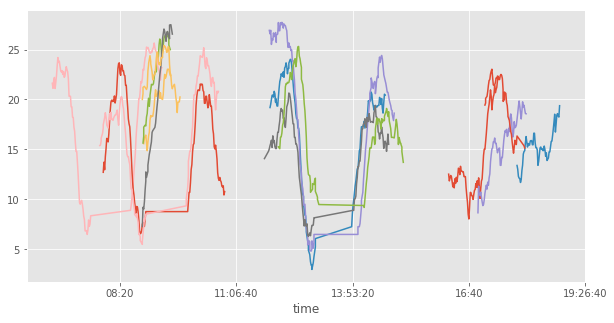

In [45]:
lines = plot_trip(trips[:15],15)

## Plot the average speed of all recorded buses within t minute intervals 

In [48]:
def plot_avg_spd(df, t):
    """ 
    Args: 
        df (pd.DataFrame): dataframe of bus data
        t (int): the granularity of each time period (in minutes) for which an average is speed is calculated
    """

    time = []
    mean = []
    for a,b in df.groupby([df['tmstmp'].dt.hour,df['tmstmp'].dt.minute-df['tmstmp'].dt.minute%t]):
        tsmp = b.tmstmp.iloc[0]         
        average = b.spd.mean()
        mean.append(average)
        if a[1] == 0:
            tsmp = tsmp.strftime('%H:00:00')
        else:
            tsmp = tsmp.strftime('%H:'+str(a[1])+':00')
        time.append(tsmp)

    return plt.scatter(time,mean)

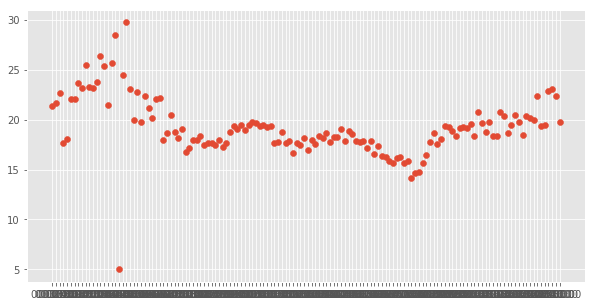

In [57]:
plot_avg_spd(vdf,10)